## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report
from message_ix.tools.add_dac import get_values

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [ ]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

## Run SSP_dev DAC baseline scenario
**Clone and create SSP_dev DAC baseline scenario**

In [44]:
SSPs = ["SSP1","SSP2","SSP5"]
mpens = ["mpen1","mpen2","mpen3","mpen4","mpen5"]
scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']

scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
             {f"1000f_v0.13_dac_{mpen}": [] for mpen in mpens} 
             for ssp in SSPs
            }


In [46]:
colors = {"SSP1":"b","SSP2":"g","SSP5":"r",}
lines = {"mpen1":"-","mpen2":"--","mpen3":"-.","mpen4":":","mpen5":"-"}

In [47]:
for k,v in scenarios.items():
    for k1,v1 in v.items():
        scen = message_ix.Scenario(mp, model=k, scenario=k1)
        acts = get_values(scen,"ACT").droplevel(["mode","time"])
        removal = (acts.loc[:, scenariotec, :, :]["lvl"].unstack().fillna(0)
                   .groupby(["node_loc"]).sum())
        removal.loc["World"] = removal.sum(axis=0)
        scenarios[k][k1] = removal
        


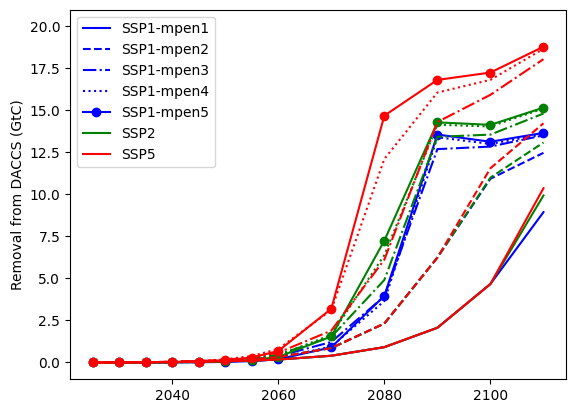

In [60]:
for ssp in SSPs:
    for mpen in mpens:
        model = f"SSP_dev_{ssp}_v0.1_dac"
        scenario = f"1000f_v0.13_dac_{mpen}"
        
        if ssp == "SSP1":
            kwargs = {"label": f"{ssp}-{mpen}"}
        elif ssp != "SSP1" and mpen == "mpen1":
            kwargs = {"label": f"{ssp}"}
        else:
            kwargs = {}
        marker = "o" if mpen == "mpen5" else "none"
        
        plt.plot(scenarios[model][scenario].div(1000).loc["World"], marker=marker, ls=lines[mpen], c=colors[ssp], **kwargs)

plt.ylim(-1,21)
plt.ylabel("Removal from DACCS (GtC)")
plt.legend()
plt.savefig("dac_ssp.jpeg",dpi=300)
plt.show()

## Close connection

In [61]:
mp.close_db()